In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from cbase.data_readers import cloudsat, viirs
from cbase.matching.match_vgac_cloudsat import DataMatcher




In [2]:


filename = "/home/a002602/data/cloud_base/cloudsat/2018150015649_64371_CS_2B-GEOPROF_GRANULE_P1_R05_E07_F03.hdf"
filename1 = "/home/a002602/data/cloud_base/cloudsat/2018150033525_64372_CS_2B-GEOPROF_GRANULE_P1_R05_E07_F03.hdf"
vgac_file = "/home/a002602/data/cloud_base/vgac/VGAC_VJ102MOD_A2018150_0130_n002738_K005.nc"
vgac_file1 = "/home/a002602/data/cloud_base/vgac/VGAC_VJ102MOD_A2018150_0312_n002739_K005.nc"



In [3]:
cld = cloudsat.read_cloudsat(filename1)
vgc = viirs.read_vgac(vgac_file1)

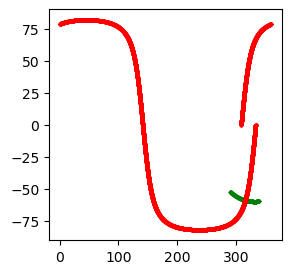

In [4]:

fig, ax = plt.subplots(1, 1, figsize=[3, 3])
ax.scatter(vgc.longitude[2500, :]%360, vgc.latitude[2500, :], c = 'g', s=2)

ax.scatter(
    cld.longitude%360,
    cld.latitude,
    c="r",s=2
)


In [5]:
dm = DataMatcher(cld, vgc)

In [ ]:
# plt.scatter(vgc.longitude[:, :]%360, vgc.latitude[:, :])
# #plt.scatter(vgc.longitude[ix, 50]%360, vgc.latitude[ix, 50])

# plt.scatter(
#     cld.longitude%360,
#     cld.latitude,
#     c="r",s=2
# )



NameError: name 'ix' is not defined

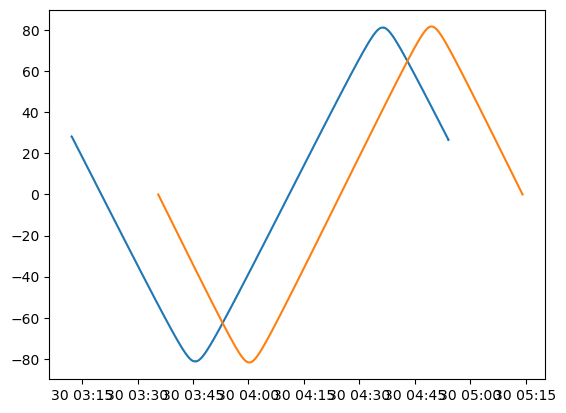

In [5]:
plt.plot(vgc.time, vgc.latitude[:, 400], label="VGAC")
plt.plot(cld.time, cld.latitude, label="CLOUDSAT")
plt.plot(vgc.time[ix], vgc.latitude[ix, 400])
plt.xlabel("time")
plt.ylabel("latitude")
plt.legend()

In [ ]:
lat1 = vgc.latitude[1000, 400]
lon1 = vgc.longitude[1000, 400]

In [300]:
from cbase.matching.match_vgac_cloudsat import DataMatcher
dm = DataMatcher(cld, vgc)

In [5]:
ac, dc, av, dv= dm.get_ascending__descending_orbit()


In [6]:
ac

array([False,  True,  True, ...,  True,  True,  True])

In [6]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import haversine_distances


In [7]:

def calculate_spatial_distance(cld, vgc, ix):
    """Compute distance between each pair of the two collections of inputs."""
    return haversine_distances(np.array([cld.latitude[dc], cld.longitude[dc]]).T, np.array([vgc.latitude[dv, ix], vgc.longitude[dv, ix]]).T)* 6371000/1000 
    #return cdist(np.array([cld.latitude[dc], cld.longitude[dc]]).T, np.array([vgc.latitude[dv, ix], vgc.longitude[dv, ix]]).T)
    #dx_a = cdist(np.array([cld.latitude[ac], cld.longitude[ac]]).T, np.array([vgc.latitude[av, 399], vgc.longitude[av, 399]]).T)

In [7]:
from cbase.utils.utils import haversine_distance
from datetime import timedelta

def custom_metric(coords1, coords2):
    lat1, lon1 = coords1
    lat2, lon2 = coords2
    return haversine_distance(lat1, lon1, lat2, lon2)

In [82]:
new_array = np.ones(vgc.latitude.shape)*-999.9

start_cloudsat = cld.time[0] - timedelta(minutes=20) + timedelta(minutes=30)
tmask_c = (cld.time > start_cloudsat) & (cld.time < start_cloudsat + timedelta(minutes=30))
tmask_v = (vgc.time > start_cloudsat) & (vgc.time < start_cloudsat + timedelta(minutes=30))

i1, i2 = 395, 410



for ix in range(i1, i2):
    print(ix)

    lon_c = np.broadcast_to(cld.longitude[tmask_c].reshape(-1, 1)%360, (cld.longitude[tmask_c].shape[0], vgc.longitude[:, ix][tmask_v].shape[0]))
    lat_c = np.broadcast_to(cld.latitude[tmask_c].reshape(-1, 1), (cld.latitude[tmask_c].shape[0], vgc.latitude[:, ix][tmask_v].shape[0]))
    lon_v = np.broadcast_to(vgc.longitude[:, ix][tmask_v].reshape(1, -1)%360, (cld.longitude[tmask_c].shape[0], vgc.longitude[:, ix][tmask_v].shape[0]))
    lat_v = np.broadcast_to(vgc.latitude[:, ix][tmask_v].reshape(1, -1), (cld.latitude[tmask_c].shape[0], vgc.latitude[:, ix][tmask_v].shape[0]))

    # dx = cdist(
    #     np.array([cld.latitude[tmask_c], cld.longitude[tmask_c]]).T, 
    #     np.array([vgc.latitude[:, ix][tmask_v], vgc.longitude[:, ix][tmask_v]]).T,
    #     )

    dx = haversine_distance(lat_c, lon_c, lat_v, lon_v)
    dsum = np.sum(dx <= 5, axis=0) 
    new_array[tmask_v, ix] = dsum
    print(dsum.max())
    
    







395
10
396
10
397
10
398
10
399
10
400
10
401
10
402
10
403
10
404
10
405
10
406
10
407
10
408
10
409
10


In [301]:
from tqdm import tqdm
i1, i2 = 300, 400
d = np.ones_like(vgc.latitude)*-999.9


times = np.ones_like(vgc.time)*-999.9
lats = np.ones_like(vgc.time)*np.nan
lons = np.ones_like(vgc.time)*np.nan
new_array = np.ones(vgc.latitude.shape)*-999.9
#for i in tqdm(range(vgc.time.shape[0])):
for i in tqdm(range(len(vgc.time))):
#for i in tqdm(range(7200, 7201)):
    tmask_c = (cld.time >= vgc.time[i]+timedelta(minutes=10)) & (cld.time <= vgc.time[i] + timedelta(minutes=15))

    if np.sum(tmask_c) == 0:
        continue
    else:

            # lon_c = np.broadcast_to(cld.longitude[tmask_c].reshape(-1, 1), (cld.longitude[tmask_c].shape[0], 1))
            # lat_c = np.broadcast_to(cld.latitude[tmask_c].reshape(-1, 1), (cld.latitude[tmask_c].shape[0], 1))
            # lon_v = np.broadcast_to(vgc.longitude[i, ix].reshape(1, -1), (cld.longitude[tmask_c].shape[0], 1))
            # lat_v = np.broadcast_to(vgc.latitude[i, ix].reshape(1, -1), (cld.latitude[tmask_c].shape[0], 1))


        lon_c = np.broadcast_to(
            cld.longitude[tmask_c].reshape(-1, 1), 
            (cld.longitude[tmask_c].shape[0], vgc.longitude[i, i1:i2].shape[0]))
        lat_c = np.broadcast_to(
            cld.latitude[tmask_c].reshape(-1, 1), 
            (cld.latitude[tmask_c].shape[0], vgc.latitude[i, i1:i2].shape[0]))
        lon_v = np.broadcast_to(
            vgc.longitude[i, i1:i2].reshape(1, -1), 
            (cld.longitude[tmask_c].shape[0], vgc.longitude[i, i1:i2].shape[0]))
        lat_v = np.broadcast_to(
            vgc.latitude[i, i1:i2].reshape(1, -1), 
            (cld.latitude[tmask_c].shape[0], vgc.latitude[i, i1:i2].shape[0]))


        dx = haversine_distance(lat_v, lon_v, lat_c, lon_c)
        min_index = np.unravel_index(np.argmin(dx), dx.shape)
        x_arg_min, y_arg_min = min_index
        new_array[i, i1:i2][y_arg_min] = cld.validation_height_base
            # imin = np.argmin(dx, axis = 1)

            # d[i, ix] = np.min(dx)
            # imin = np.argmin(dx)
            # lons[i] = vgc.longitude[i, ix]
            # lats[i] = vgc.latitude[i, ix]
            # tdiff = cld.time[tmask_c][imin] - vgc.time[i]
            # times[i] = tdiff.days * 24 * 60 + tdiff.seconds/60

            # if np.any(dx < 250):
            #     new_array[i, ix] = 100    


100%|██████████| 10313/10313 [05:38<00:00, 30.49it/s]


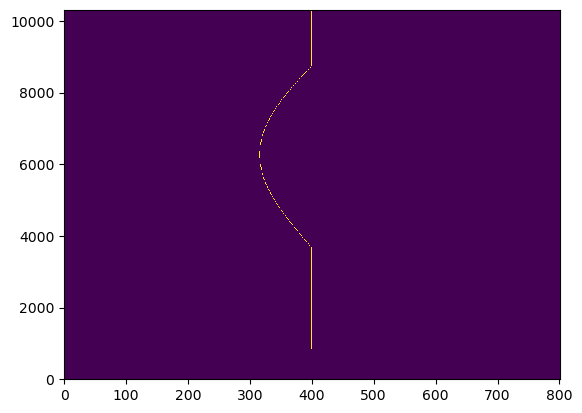

In [302]:
cs = plt.pcolormesh(new_array, vmin=0, vmax=100)

7200


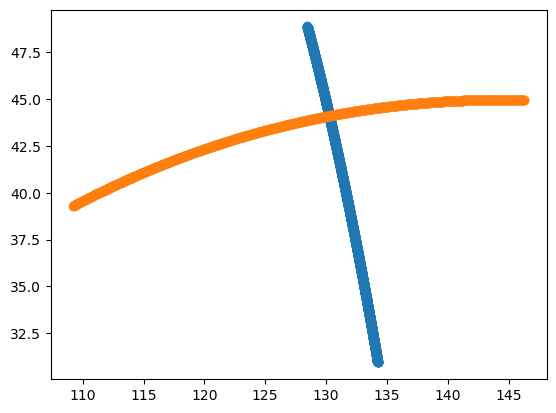

In [281]:
print(i)
plt.scatter(cld.longitude[tmask_c]%360, cld.latitude[tmask_c])
plt.scatter(vgc.longitude[i, :]%360, vgc.latitude[i, :])

In [303]:
for itime in enumerate(vgc.time):
    print(itime)

(0, datetime.datetime(2018, 5, 30, 3, 12, 9, 538611))
(1, datetime.datetime(2018, 5, 30, 3, 12, 11, 325193))
(2, datetime.datetime(2018, 5, 30, 3, 12, 11, 325193))
(3, datetime.datetime(2018, 5, 30, 3, 12, 13, 111777))
(4, datetime.datetime(2018, 5, 30, 3, 12, 13, 111777))
(5, datetime.datetime(2018, 5, 30, 3, 12, 13, 111777))
(6, datetime.datetime(2018, 5, 30, 3, 12, 14, 898381))
(7, datetime.datetime(2018, 5, 30, 3, 12, 14, 898381))
(8, datetime.datetime(2018, 5, 30, 3, 12, 14, 898381))
(9, datetime.datetime(2018, 5, 30, 3, 12, 16, 684965))
(10, datetime.datetime(2018, 5, 30, 3, 12, 16, 684965))
(11, datetime.datetime(2018, 5, 30, 3, 12, 16, 684965))
(12, datetime.datetime(2018, 5, 30, 3, 12, 18, 471547))
(13, datetime.datetime(2018, 5, 30, 3, 12, 18, 471547))
(14, datetime.datetime(2018, 5, 30, 3, 12, 18, 471547))
(15, datetime.datetime(2018, 5, 30, 3, 12, 20, 258130))
(16, datetime.datetime(2018, 5, 30, 3, 12, 20, 258130))
(17, datetime.datetime(2018, 5, 30, 3, 12, 20, 258130))
(18

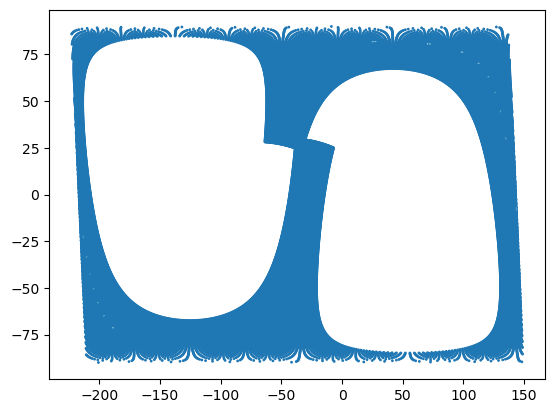

In [299]:
cs = plt.scatter(vgc.longitude[::10, ::10], vgc.latitude[::10, ::10], c=new_array[::10, ::10], cmap="tab20", vmin=0, vmax = 10, s = 1)
#plt.colorbar(cs)

In [237]:
new_array.max()

28.0

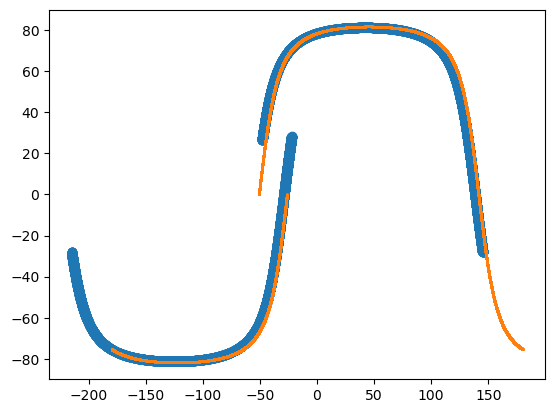

In [42]:
plt.scatter(vgc.longitude[:, 399], vgc.latitude[:, 399])
plt.scatter(cld.longitude, cld.latitude, s=1)
# plt.scatter(vgc.longitude[i ,ix], vgc.latitude[i, ix],c="r")
# cs = plt.scatter(
#     vgc.longitude[:, i1:i2], 
#     vgc.latitude[:, i1:i2], 
#     c = new_array[:, i1:i2], 
#     vmin = -1, vmax = 10, s = 1)

# plt.scatter(
#     cld.longitude[:][tmask_c]%360, 
#     cld.latitude[:][tmask_c],
#     s=1)
# plt.colorbar(cs)



In [284]:
d = haversine_distance(lat_v[0], lon_v[0], lat_c, lon_c)
print(lon_c[722], lat_c[722], lat_v[0], lon_v[0])


[-27.83597565] [-7.00731373] [-6.8229275] [-28.684273]


In [280]:
for i in range(len(lon_c)):
    print(lat_v[0], lon_v[0], lat_c[i], lon_c[i])
    print(haversine_distance(lat_v[0], lon_v[0], lat_c[i], lon_c[i]))

[-6.8229275] [-28.684273] [-0.00479246] [-26.34058571]
[801.48197043]
[-6.8229275] [-28.684273] [-0.01449278] [-26.34264946]
[800.38713434]
[-6.8229275] [-28.684273] [-0.0241931] [-26.34471512]
[799.29225119]
[-6.8229275] [-28.684273] [-0.03389342] [-26.34677887]
[798.1974585]
[-6.8229275] [-28.684273] [-0.04359373] [-26.34884262]
[797.10268808]
[-6.8229275] [-28.684273] [-0.05329406] [-26.35090637]
[796.00793924]
[-6.8229275] [-28.684273] [-0.06299438] [-26.35297203]
[794.91314364]
[-6.8229275] [-28.684273] [-0.0726947] [-26.35503578]
[793.818439]
[-6.8229275] [-28.684273] [-0.08239502] [-26.35709953]
[792.72375661]
[-6.8229275] [-28.684273] [-0.09209534] [-26.35916519]
[791.62902764]
[-6.8229275] [-28.684273] [-0.10179566] [-26.36122894]
[790.53439002]
[-6.8229275] [-28.684273] [-0.11149598] [-26.36329269]
[789.43977494]
[-6.8229275] [-28.684273] [-0.12119629] [-26.36535835]
[788.34511424]
[-6.8229275] [-28.684273] [-0.13089661] [-26.3674221]
[787.25054451]
[-6.8229275] [-28.684273] 

In [ ]:
from datetime import timedelta
for i in range(len(vgc.latitude[av, :])):
    ix = ix_all[0]
    lats_c = cld.latitude[ac][ix-10:ix+10]
    lons_c = cld.longitude[ac][ix-10:ix+10]

    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
dt = cdist(np.array([time.timestamp() for time in cld.time]).reshape(-1, 1),    
np.array([time.timestamp() for time in vgc.time]).reshape(-1, 1))

In [ ]:

ix = dx.argmin(axis=0)

ix_a = dx_a.argmin(axis=0)



In [ ]:
dx_subset = dx[ix, :]

In [ ]:
dx_subset.shape

(5132, 5132)

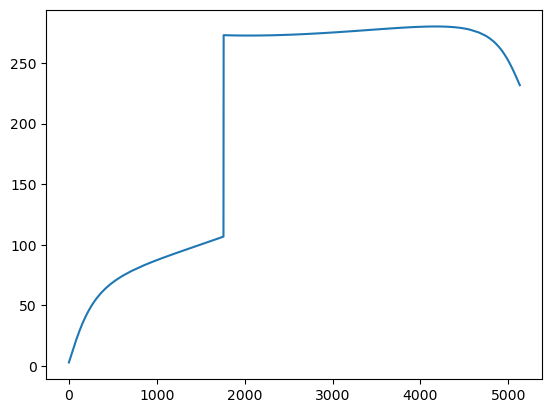

In [ ]:
plt.plot(dx[1, :])

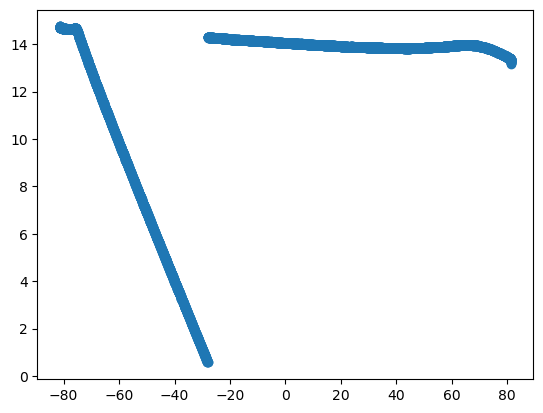

In [ ]:
t_diff = [(t_c - t_v).days*24*60 + (t_c - t_v).seconds/60 for t_c, t_v in zip(cld.time[dc][ix], vgc.time[dv])]
t_diff_a = [(t_c - t_v).days*24*60 + (t_c - t_v).seconds/60 for t_c, t_v in zip(cld.time[ac][ix_a], vgc.time[av])]
plt.scatter(vgc.latitude[dv, 400], t_diff)

In [ ]:
len(t_diff_a)
vgc.longitude[dv].shape

(5132, 801)

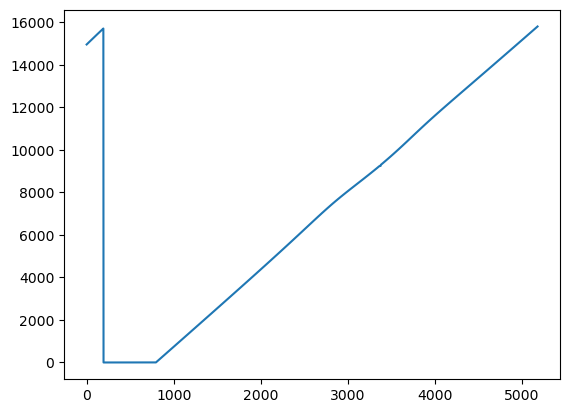

In [ ]:
plt.plot(ix_a)

In [ ]:
tmask = ~np.isnan(np.where((dt < 25 * 60)&(dt > 20*60), dt, np.nan))

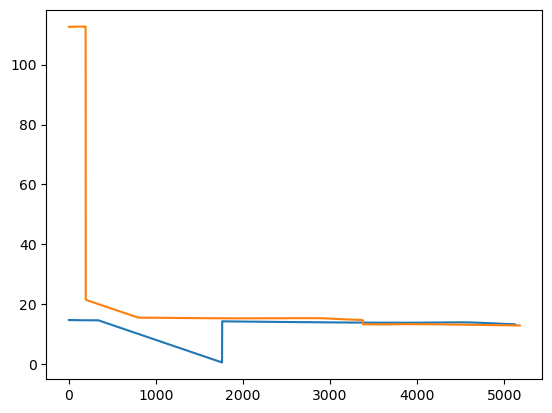

In [ ]:

plt.plot(t_diff)
plt.plot(t_diff_a)

In [ ]:
np.sum(np.array(t_diff_a) < 0)

0

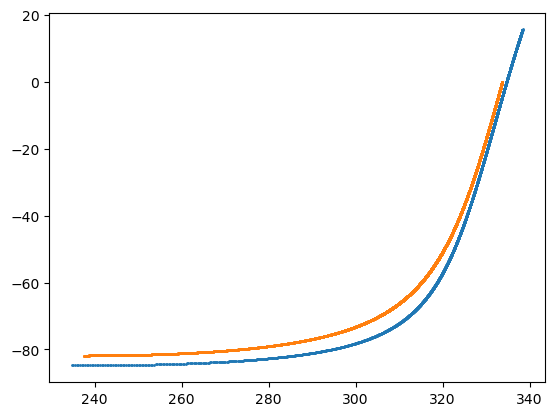

In [25]:
#cs = plt.scatter(vgc.longitude[dv, 400]%360, vgc.latitude[dv, 400], c= t_diff, cmap="coolwarm", vmin=-45, vmax=45)
ix = 500
cs = plt.scatter(vgc.longitude[av, ix][tmask_v]%360, vgc.latitude[av, ix][tmask_v], s=1)
cs = plt.scatter(cld.longitude[ac][tmask_c]%360, cld.latitude[ac][tmask_c], s=1)



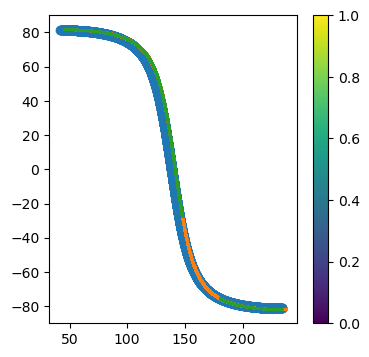

In [ ]:
fig, ax= plt.subplots(1,1, figsize=[4,4])
ax.scatter(vgc.longitude[dv, 399]%360, vgc.latitude[dv, 399])
ax.scatter(cld.longitude[dc]%360, cld.latitude[dc], s=1)
cs = ax.scatter(cld.longitude[dc][ix]%360, cld.latitude[dc][ix], s=0.5)
fig.colorbar(cs)


In [ ]:
vgc.latitude.shape

(10313, 801)

NameError: name 'av' is not defined

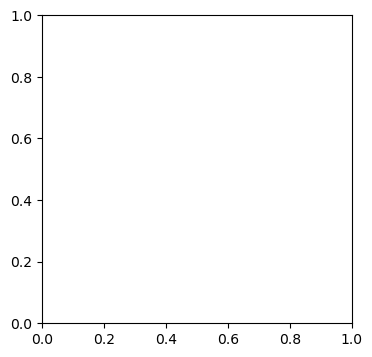

In [ ]:
fig, ax= plt.subplots(1,1, figsize=[4,4])
ax.scatter(vgc.latitude[av, 400], cld.latitude[ac][ix], s=1)

xx = np.arange(-90, 90, 1)
ax.plot(xx, xx, 'r--')

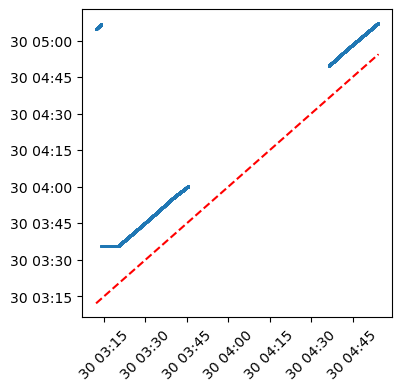

In [ ]:
fig, ax= plt.subplots(1,1, figsize=[4,4])
ax.scatter(vgc.time[av], cld.time[ac][ix], s=1)
ax.tick_params(axis='x', labelrotation=45)
xx = vgc.time
ax.plot(xx, xx, 'r--')

In [ ]:
hours = [(time1 - time2).seconds/3600 for time1, time2 in zip(cld.time[ix], vgc.time)]

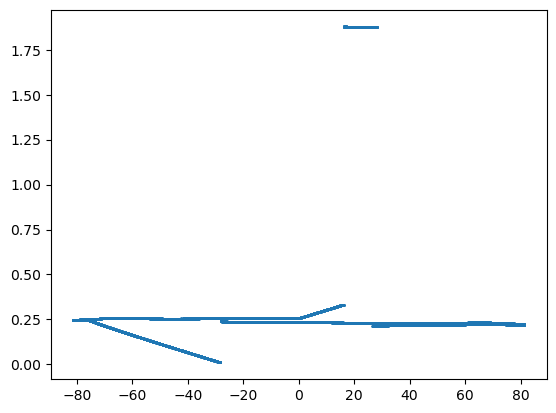

In [ ]:
plt.scatter(vgc.latitude[:, 400], hours, s=1)